In [1]:
import sys,os
from glob import glob
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import wand.image as wi
from PIL import Image

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import gan_resources as ganr

%matplotlib inline
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Num GPUs Available:  1
2.6.0


Lets start by defining some functions for handling the images.

These are Standard Confs for remainder of the work.

In [2]:
content_layers=['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

style_weight=30
content_weight=20

style_weights = {'block1_conv1': 0.7,
                 'block2_conv1': 0.2,
                 'block3_conv1': 0.25,
                 'block4_conv1': 0.1,
                 'block5_conv1': 0.25}

In [3]:
ROOT_DIR = os.path.abspath(os.curdir).split('jupyter_notebooks')[0]

with open(ROOT_DIR+"keys/personal_paths.json", "r") as handler:
    info = json.load(handler)

style_paths = info["style_paths"]
img_paths = info['image_paths']

style_img_list =[]
content_img_list=[]
style_img_name_list= []
content_img_name_list = []

#plt.figure(figsize=(12,12))
for number,filename in enumerate(os.listdir(style_paths[2])):
    style_img= ganr.load_image(style_paths[2]+filename)
    style_img_list.append(style_img)
    style_img_name_list.append(filename)

repeat_list_check = []
for number, filename in enumerate(os.listdir(img_paths[1])):
    if filename not in repeat_list_check:
        if '.jpg' not in filename:
            new_filepath = ganr.handle_format(img_paths[1]+filename)
            content_img= ganr.load_image(new_filepath)
            content_img_name_list.append(new_filepath.replace(img_paths[1],''))
            content_img_list.append(content_img)
            repeat_list_check.append(new_filepath.replace(img_paths[1],''))
        else:
            content_img=ganr.load_image(img_paths[1]+filename)
            content_img_name_list.append(filename)
            content_img_list.append(content_img)

In [4]:
class entire_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(entire_model, self).__init__()
        self.vgg=ganr.my_model(style_layers + content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False

    def call(self, inputs):
        inputs=inputs*255.0 
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)

        style_outputs, content_outputs=(outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs=[ganr.gram_matrix(layer) for layer in style_outputs]

        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                for style_name, value
                in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


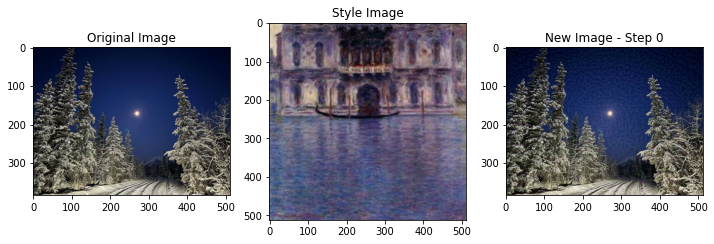

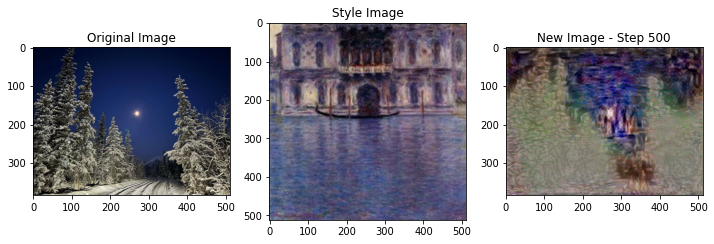

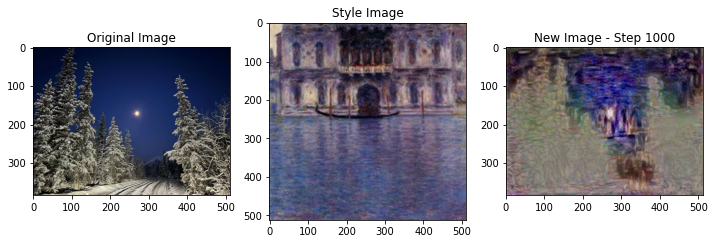

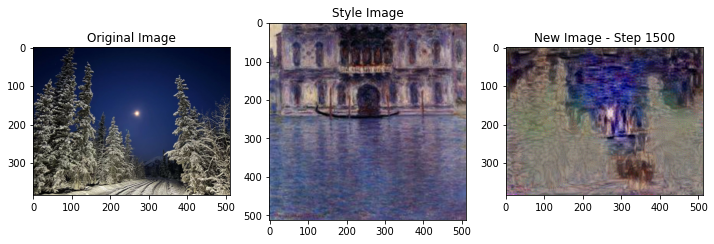

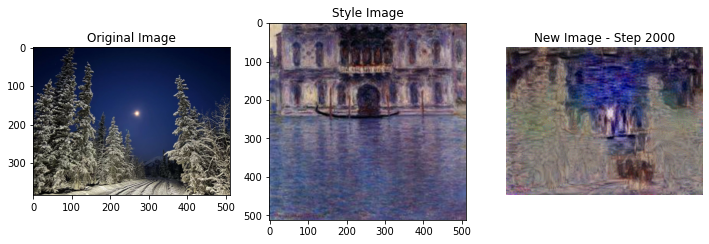

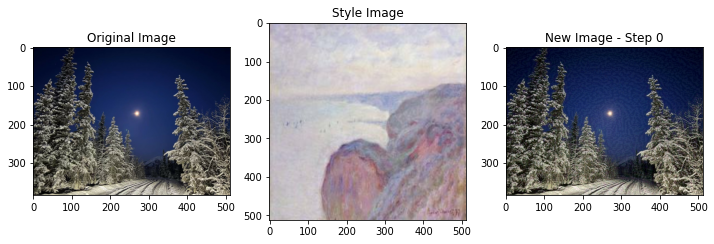

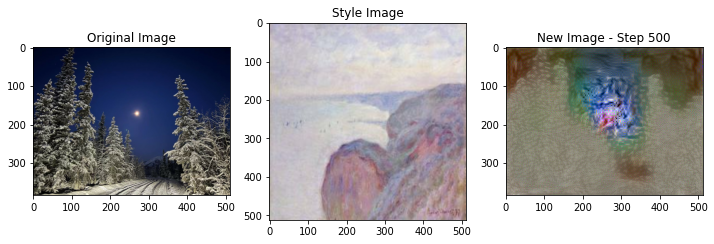

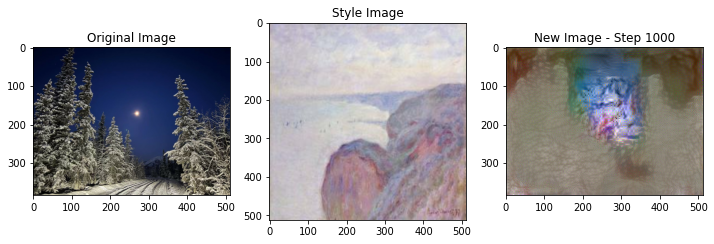

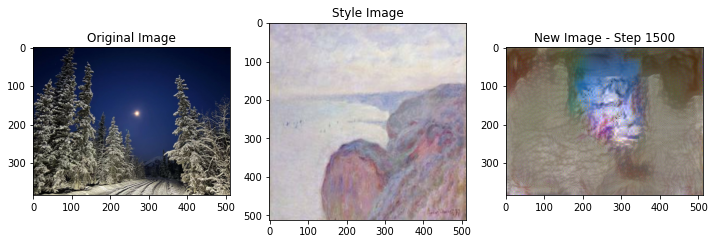

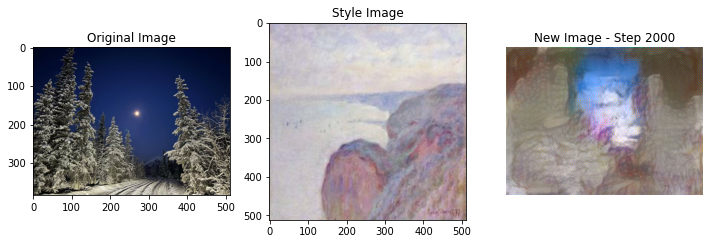

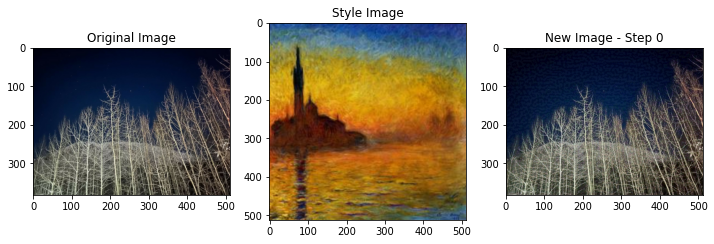

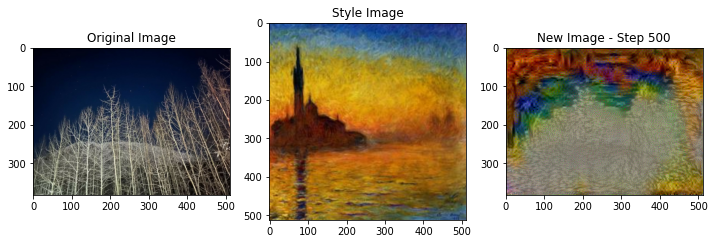

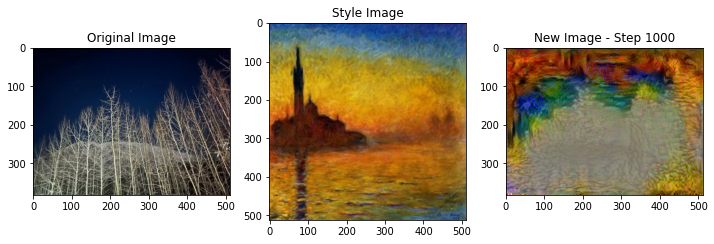

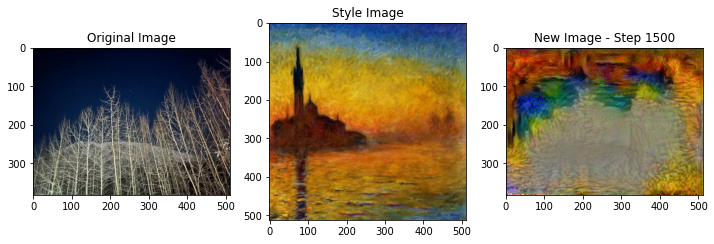

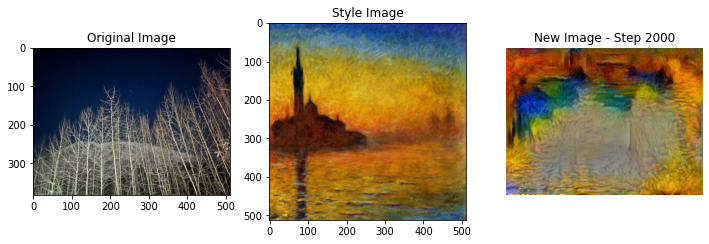

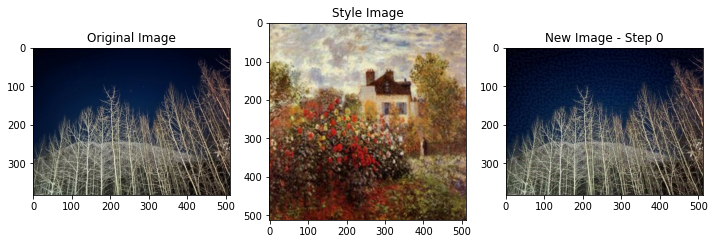

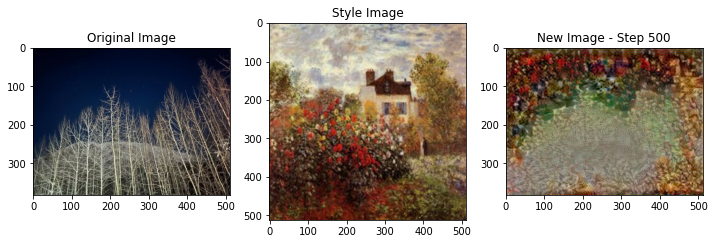

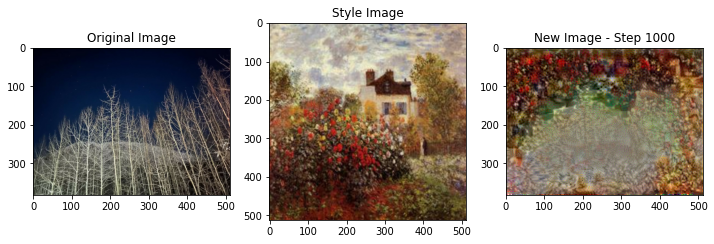

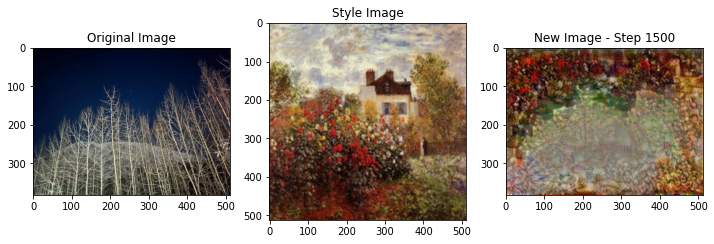

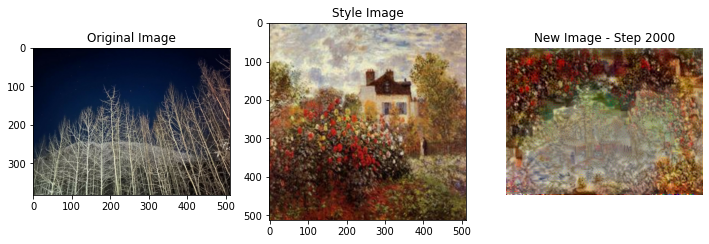

In [5]:
# Now begins the job.
# Iterating (i) through each image in the content image list.
# for each iteration we are doing 10 random iterations of anything between 
for i,content_img in enumerate(content_img_list):
    x=tf.keras.applications.vgg19.preprocess_input(content_img*255)
    x=tf.image.resize(x, (256,256))
    content_name = content_img_name_list[i]
    rand_img_indexes = np.random.choice(a=len(style_img_list), size=2 )
    style_img_list_rand = [ style_img_list[rand_ind] for rand_ind in rand_img_indexes]
    for j,style_img in enumerate(style_img_list_rand):
        style_name = style_img_name_list[j]
        vgg_model=tf.keras.applications.VGG19(include_top=True, weights='imagenet')
        vgg_model.trainable=False

        style_extractor = ganr.my_model(style_layers)
        style_outputs = style_extractor(style_img*255)
        
        extractor=entire_model(style_layers, content_layers)
        style_targets = extractor(style_img)['style']
        content_targets = extractor(content_img)['content']

        results = extractor(tf.constant(content_img))

        generate_image = tf.Variable(content_img)
        opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
        
        
        @tf.function()
        def train_step(image):
            with tf.GradientTape() as tape:
                outputs = extractor(image)
                loss = ganr.total_cost(outputs,style_weight,style_weights,style_targets,style_layers,content_weight,content_layers,content_targets)

            grad = tape.gradient(loss, image)
            opt.apply_gradients([(grad, image)])
            image.assign(ganr.clip_0_1(image))
            
        num_iterations=2500
        for i in range(num_iterations):
            train_step(generate_image)
            if(i%500==0):
                plt.figure(figsize=(12,12))
                plt.subplot(1, 3, 1)
                ganr.imshow(content_img, 'Original Image')
                plt.subplot(1, 3, 2)
                ganr.imshow(style_img, 'Style Image')
                plt.subplot(1, 3, 3)
                ganr.imshow(np.squeeze(generate_image.read_value(), 0), 'New Image - Step '+str(i))
        train_step(generate_image)
        plt.imshow(np.squeeze(generate_image.read_value(), 0))
        plt.axis('off')
        fig1 = plt.gcf()
        fig1.savefig(f'{ROOT_DIR}results/{content_name}_and_{style_name}.png', bbox_inches='tight')